## Loading the dataset and training an image classifier

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import torch.optim as optim
from torch import nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Defining the paths

path_data = os.path.join(os.path.dirname(os.getcwd()),"Data")
path_images = os.path.join(path_data,"images\\images")
path_images

'd:\\Study\\Conda Projects\\opdl\\Data\\images\\images'

In [5]:
path_labels = os.path.join(path_data,"annotations.csv")
path_labels

'd:\\Study\\Conda Projects\\opdl\\Data\\annotations.csv'

In [6]:
path_test_labels = os.path.join(path_data,"annotations_test.csv")
path_test_labels

'd:\\Study\\Conda Projects\\opdl\\Data\\annotations_test.csv'

### Loading the dataset using custom loader

In [7]:
# Loading the dataset

class dogCatDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.to_list()
        
        img_name = os.path.join(self.root_dir,self.labels.iloc[index,0])
        img_name = img_name +".jpg"
        image = cv2.imread(img_name)
        label = self.labels.iloc[index,1]

        if self.transform:
            image = self.transform(image)
        
        return image,label

In [8]:
# Defining the transform

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

In [9]:
# Creating the dataset
dataset_cd = dogCatDataset(csv_file=path_labels, root_dir=path_images, transform=transform)
dataloader_cd = DataLoader(dataset_cd, batch_size=32, shuffle=True)

In [10]:
dataset_test = dogCatDataset(csv_file=path_test_labels, root_dir=path_images, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [11]:
len(dataset_cd)

3680

In [12]:
for i, sample in enumerate(dataset_cd):
    print(i, sample[0].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


### Building the neural network

In [13]:
from torchvision.models import resnet50

In [14]:
model = resnet50(pretrained=True)

d:\Study\Conda Projects\opdl\opdl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Study\Conda Projects\opdl\opdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Changing the final layer based on the number of classes
model.fc = nn.Linear(model.fc.in_features,1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Specity the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
from tqdm import tqdm

In [18]:
model.train()
num_epochs = 10
for epoch in range(num_epochs):   
    running_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0.0
    for images, labels in tqdm(dataloader_cd):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        labels -= 1
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)
    epoch_loss = running_loss / len(dataset_cd)
    accuracy = correct_predictions / total_samples
    print('Epoch [{}/{}],Accuracy:{:.4f}, Loss: {:.4f}'.format(epoch+1, num_epochs,accuracy, epoch_loss))

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [04:23<00:00,  2.29s/it]


Epoch [1/10],Accuracy:0.9677, Loss: 0.0874


100%|██████████| 115/115 [03:09<00:00,  1.65s/it]


Epoch [2/10],Accuracy:0.9965, Loss: 0.0117


100%|██████████| 115/115 [03:20<00:00,  1.74s/it]


Epoch [3/10],Accuracy:0.9951, Loss: 0.0161


100%|██████████| 115/115 [03:08<00:00,  1.64s/it]


Epoch [4/10],Accuracy:0.9948, Loss: 0.0197


100%|██████████| 115/115 [03:12<00:00,  1.67s/it]


Epoch [5/10],Accuracy:0.9989, Loss: 0.0046


100%|██████████| 115/115 [03:11<00:00,  1.67s/it]


Epoch [6/10],Accuracy:0.9989, Loss: 0.0036


100%|██████████| 115/115 [03:12<00:00,  1.67s/it]


Epoch [7/10],Accuracy:0.9935, Loss: 0.0188


100%|██████████| 115/115 [03:18<00:00,  1.72s/it]


Epoch [8/10],Accuracy:0.9951, Loss: 0.0174


100%|██████████| 115/115 [03:10<00:00,  1.65s/it]


Epoch [9/10],Accuracy:0.9978, Loss: 0.0075


100%|██████████| 115/115 [03:03<00:00,  1.59s/it]

Epoch [10/10],Accuracy:0.9997, Loss: 0.0018


In [89]:
# Using the model for inference

model = model.eval()
losses = []
correct_predictions = 0
with torch.no_grad():
    for inputs, labels in tqdm(dataloader_test):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        labels -= 1
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        # correct_predictions += torch.sum(outputs == labels)
        losses.append(loss.item())
        predicted_labels = (torch.sigmoid(outputs) > 0.5).squeeze(1).long()
        correct_predictions += (predicted_labels == labels).sum().item()
print(correct_predictions / len(dataset_test), np.mean(losses))

100%|██████████| 115/115 [02:36<00:00,  1.36s/it]

18.490869446715728 0.04763443799507197


In [22]:
print(correct_predictions)
print(len(dataset_test))

67856.0
3669


### Inferencing one image

In [117]:
path_test_image = os.path.join(path_images,"pomeranian_3.jpg")
# path_test_image = os.path.join(path_images,"Bombay_74.jpg")
test_image = cv2.imread(path_test_image)
test_image = transform(test_image)

In [118]:
model.eval()
test_image = test_image.unsqueeze(0)
test_image = test_image.to(device)
test_image.size()

torch.Size([1, 3, 224, 224])

In [119]:
output_test = model(test_image)
predicted_label_test = (torch.sigmoid(output_test) > 0.5).squeeze(1).long()

In [120]:
predicted_label_test

tensor([1], device='cuda:0')

### Grad-CAM 

In [20]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [21]:
target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(0)]

In [22]:
cam = GradCAM(model=model, target_layers=target_layers)

In [58]:
path_test_image = os.path.join(path_images,"pomeranian_3.jpg")
test_image = cv2.imread(path_test_image)
test_image = transform(test_image)
test_image = test_image.unsqueeze(0)
test_image = test_image.to(device)

In [59]:
grayscale_cam = cam(input_tensor=test_image, targets=targets)
test_image_cam = cv2.imread(path_test_image)
test_image_cam = cv2.resize(test_image_cam,(224,224))
test_image_cam = test_image_cam/255
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(test_image_cam, grayscale_cam, use_rgb=True)

In [60]:
import matplotlib.pyplot as plt

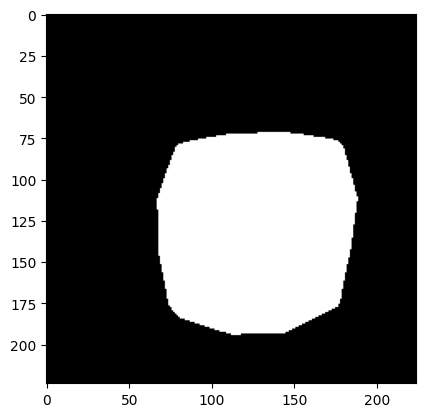

In [61]:
grayscale_cam_img = np.where(grayscale_cam>0.58,255,0)
plt.imshow(grayscale_cam_img,cmap='gray')
plt.show()

In [43]:
from PIL import Image

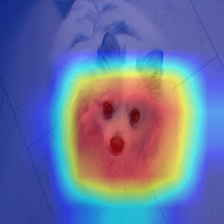

In [44]:
Image.fromarray(visualization)

### Saving the model weights

In [19]:
torch.save(model.state_dict(),os.path.join(os.path.dirname(os.getcwd()),"checkpoints\\model_oxf_resnet50_epochs10.pth"))